In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-21 14:06:40.272179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
22 - PPI_Hub_Proteins
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(2862, 71)


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,AAAS,0.000101,-0.037931,-0.036681,-0.027198,0.043804,-0.037495,0.036276,0.006421,0.008637,...,0.004682,0.010450,0.000324,0.004844,0.024128,0.008368,-0.008839,0.006769,0.035937,0.016593
1,AAMP,-0.011206,0.023624,-0.017611,0.022335,0.034596,-0.042634,0.009411,-0.013815,-0.013696,...,0.005329,-0.037666,-0.012470,-0.003478,0.015595,-0.011644,-0.014867,0.001246,-0.020725,-0.021174
2,AARS1,-0.014978,-0.039624,-0.023902,0.011588,0.001689,0.027187,0.026177,-0.050210,-0.013767,...,0.023402,-0.013334,-0.049046,0.026138,0.000754,0.013036,0.007455,0.017787,-0.017051,0.007649
3,AARS2,-0.033118,-0.011848,-0.057877,0.009614,0.018117,0.062050,0.055039,-0.036307,-0.006781,...,0.004676,-0.052899,-0.028335,-0.000572,-0.002464,0.004491,-0.004105,-0.045096,-0.013774,-0.026740
4,AASDHPPT,-0.015627,0.019984,-0.023834,0.060897,-0.001235,0.035667,-0.020289,0.009512,-0.015328,...,0.014733,-0.035435,-0.046767,0.029246,0.017557,0.022444,0.011002,-0.009545,-0.030216,-0.047760


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.csv.gz")
combo_gsea_df.to_csv(combo_gsea_dir, compression = 'gzip')


In [9]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
protein phosphorylation (GO:0006468),-0.392173,-12.440640,1.572387e-35,1.284640e-32,1.284640e-32,71,"PRKACA,PRKCE,CDK4,CTBP1,CHEK2,AURKB,GSK3B,IKBK...",z_16,real
"negative regulation of transcription, DNA-templated (GO:0045892)",-0.285373,-9.336230,9.982560e-21,8.155752e-18,2.718584e-18,95,"RUNX2,SIRT1,CIR1,TIMELESS,PPARG,CTBP1,AHR,TRAF...",z_16,real
"mRNA splicing, via spliceosome (GO:0000398)",-0.286450,-9.127431,7.014370e-20,5.730740e-17,1.432685e-17,127,"CWC22,CPSF4,ZMAT5,U2AF2,ZCRB1,METTL14,SNRNP25,...",z_16,real
regulation of transcription from RNA polymerase II promoter (GO:0006357),-0.270206,-8.819208,1.152721e-18,9.417733e-16,1.883547e-16,101,"RUNX2,MYCN,ELP2,SUPT4H1,ACTL6A,FOXA2,GMEB1,AHR...",z_16,real
proteasome-mediated ubiquitin-dependent protein catabolic process (GO:0043161),-0.260303,-8.647532,5.262498e-18,4.299461e-15,7.165768e-16,84,"SIRT1,ANAPC4,UBE2K,PSMD1,CDC16,UBE2R2,RNF111,P...",z_16,real
...,...,...,...,...,...,...,...,...,...
viral transcription (GO:0019083),0.237512,7.991574,1.442211e-15,1.178287e-12,9.819055e-14,76,"RPL18A,RPL3,RPL32,RPL17,RPL18,POM121,RPS9,RPS1...",z_16,real
viral transcription (GO:0019083),0.410742,inf,6.075866e-17,4.963982e-14,4.963982e-14,76,"RPS3,NUP214,RPL22,RPS8,NUP43,RPL35,RPL10A,RPL2...",z_62,real
protein ubiquitination (GO:0016567),0.296468,inf,7.415649e-23,6.058585e-20,3.029292e-20,74,"MDM2,RNF25,PCNA,CAND1,BCL10,USP7,UBE2T,PEX10,C...",z_16,real


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

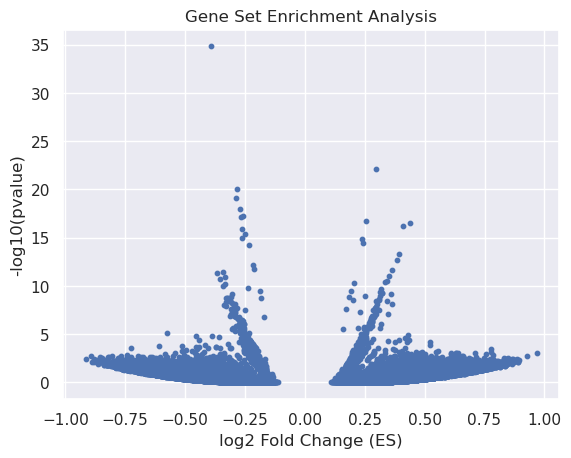

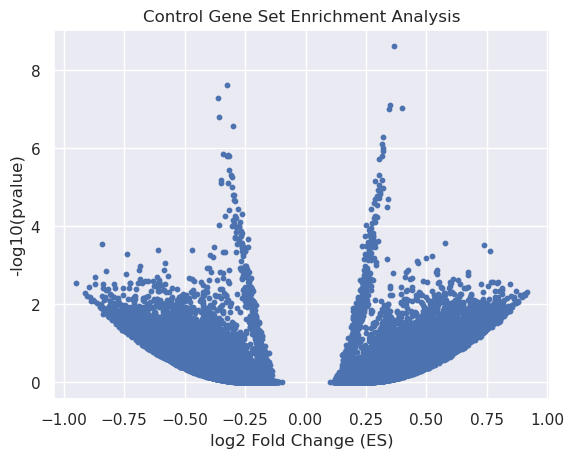

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [11]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()